# **After cleaning**

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':18})

In [46]:
import pyspark as ps
import pandas as pd
from pyspark.sql.functions import lit

In [47]:
# look at df created with spark importer

df = pd.read_csv('../data/2020-08-11_all_clean.csv', lineterminator='\n', parse_dates=['tweet_date_created', 'user_date_created'])
df.head()

,tweet_id,state,search_term_key,tweet_date_created,user_id,user_date_created,location,description,user_verified,tweet_text_wo_mentions,source_text
0,1246830993903955968,AR,@joebiden,2020-04-05 16:04:08+00:00,29214401,2009-04-06 14:53:51+00:00,NaN,The son of Rage and Love,False,"lil pump really said ""look at my wrist corona ...",Twitter for Android
1,1246830994537222144,AR,@joebiden,2020-04-05 16:04:08+00:00,4766479674,2016-01-16 04:42:14+00:00,"geohell, disneyworld",i'm a fully automated toilet,False,@Stephan59177054 @NomikiKonst @JoeBiden I thou...,Twitter for Android
2,1246830995132813312,AR,@joebiden,2020-04-05 16:04:08+00:00,3166145611,2015-04-21 02:02:20+00:00,NaN,Trump supporter! I follow back all Patriots. ...,False,RT @Jali_Cat: Yet you’ve been in office since ...,Twitter Web App
3,1246830995761963008,AR,@joebiden,2020-04-05 16:04:09+00:00,2868989345,2014-11-09 14:12:09+00:00,"North Huntingdon, PA",NaN,False,@JoeBiden This is a better message and more co...,Twitter for iPad
4,1246830995795369984,AR,@joebiden,2020-04-05 16:04:09+00:00,91865200,2009-11-22 20:47:43+00:00,Colorado,#the Resistance🇱🇷,False,RT @KaivanShroff: “I think it’s close to crimi...,Twitter for iPhone


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117652 entries, 0 to 117651
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype              
---  ------                  --------------   -----              
 0   tweet_id                117652 non-null  int64              
 1   state                   117652 non-null  object             
 2   search_term_key         117652 non-null  object             
 3   tweet_date_created      117652 non-null  datetime64[ns, UTC]
 4   user_id                 117652 non-null  int64              
 5   user_date_created       117652 non-null  datetime64[ns, UTC]
 6   location                85966 non-null   object             
 7   description             99927 non-null   object             
 8   user_verified           117652 non-null  bool               
 9   tweet_text_wo_mentions  117652 non-null  object             
 10  source_text             117652 non-null  object             
dtypes: bool(1), datetime64[ns,

In [49]:
import re

In [50]:
tweet_text = df['tweet_text_wo_mentions']

In [51]:
retweet_regex = "^RT @"
mentions_regex = "^@"

retweets = [tweet for tweet in tweet_text if re.search(retweet_regex, tweet)]

In [52]:
len(retweets)

39692

In [53]:
len(tweet_text)

117652

In [54]:
len(retweets)/len(tweet_text)

0.33736783055111685

In [55]:
df['is_rt'] = [True if re.search(retweet_regex, tweet) else False for tweet in tweet_text]
df.head()

,tweet_id,state,search_term_key,tweet_date_created,user_id,user_date_created,location,description,user_verified,tweet_text_wo_mentions,source_text,is_rt
0,1246830993903955968,AR,@joebiden,2020-04-05 16:04:08+00:00,29214401,2009-04-06 14:53:51+00:00,NaN,The son of Rage and Love,False,"lil pump really said ""look at my wrist corona ...",Twitter for Android,False
1,1246830994537222144,AR,@joebiden,2020-04-05 16:04:08+00:00,4766479674,2016-01-16 04:42:14+00:00,"geohell, disneyworld",i'm a fully automated toilet,False,@Stephan59177054 @NomikiKonst @JoeBiden I thou...,Twitter for Android,False
2,1246830995132813312,AR,@joebiden,2020-04-05 16:04:08+00:00,3166145611,2015-04-21 02:02:20+00:00,NaN,Trump supporter! I follow back all Patriots. ...,False,RT @Jali_Cat: Yet you’ve been in office since ...,Twitter Web App,True
3,1246830995761963008,AR,@joebiden,2020-04-05 16:04:09+00:00,2868989345,2014-11-09 14:12:09+00:00,"North Huntingdon, PA",NaN,False,@JoeBiden This is a better message and more co...,Twitter for iPad,False
4,1246830995795369984,AR,@joebiden,2020-04-05 16:04:09+00:00,91865200,2009-11-22 20:47:43+00:00,Colorado,#the Resistance🇱🇷,False,RT @KaivanShroff: “I think it’s close to crimi...,Twitter for iPhone,True


In [56]:
df['state'].unique()

array(['AR', 'CO', 'OR'], dtype=object)

In [57]:
# create dicts for target encoding
state_dict = {'AR':1, 'CO':2, 'OR':3}
term_dict = {'@joebiden':1, '@joebiden_#COVID19':2, '#COVID19':3, '@realdonaldtrump_#COVID19':4, '@realdonaldtrump':5}

df.replace({'state': state_dict, 'search_term_key': term_dict}, inplace=True)


In [58]:
# create X matrix, drop cols
drop_cols = ['tweet_id', 'tweet_date_created', 'user_id', 'location']
new_df = df.drop(drop_cols, axis=1)
new_df.head()

,state,search_term_key,user_date_created,description,user_verified,tweet_text_wo_mentions,source_text,is_rt
0,1,1,2009-04-06 14:53:51+00:00,The son of Rage and Love,False,"lil pump really said ""look at my wrist corona ...",Twitter for Android,False
1,1,1,2016-01-16 04:42:14+00:00,i'm a fully automated toilet,False,@Stephan59177054 @NomikiKonst @JoeBiden I thou...,Twitter for Android,False
2,1,1,2015-04-21 02:02:20+00:00,Trump supporter! I follow back all Patriots. ...,False,RT @Jali_Cat: Yet you’ve been in office since ...,Twitter Web App,True
3,1,1,2014-11-09 14:12:09+00:00,NaN,False,@JoeBiden This is a better message and more co...,Twitter for iPad,False
4,1,1,2009-11-22 20:47:43+00:00,#the Resistance🇱🇷,False,RT @KaivanShroff: “I think it’s close to crimi...,Twitter for iPhone,True


In [59]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117652 entries, 0 to 117651
Data columns (total 8 columns):
 #   Column                  Non-Null Count   Dtype              
---  ------                  --------------   -----              
 0   state                   117652 non-null  int64              
 1   search_term_key         117652 non-null  int64              
 2   user_date_created       117652 non-null  datetime64[ns, UTC]
 3   description             99927 non-null   object             
 4   user_verified           117652 non-null  bool               
 5   tweet_text_wo_mentions  117652 non-null  object             
 6   source_text             117652 non-null  object             
 7   is_rt                   117652 non-null  bool               
dtypes: bool(2), datetime64[ns, UTC](1), int64(2), object(3)
memory usage: 5.6+ MB


In [62]:
# must have usr desc for text analysis
new_df = new_df.dropna()
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99927 entries, 0 to 117651
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   state                   99927 non-null  int64              
 1   search_term_key         99927 non-null  int64              
 2   user_date_created       99927 non-null  datetime64[ns, UTC]
 3   description             99927 non-null  object             
 4   user_verified           99927 non-null  bool               
 5   tweet_text_wo_mentions  99927 non-null  object             
 6   source_text             99927 non-null  object             
 7   is_rt                   99927 non-null  bool               
dtypes: bool(2), datetime64[ns, UTC](1), int64(2), object(3)
memory usage: 5.5+ MB


In [63]:
targets = new_df[['state','search_term_key']]
targets

,state,search_term_key
0,1,1
1,1,1
2,1,1
4,1,1
5,1,1
...,...,...
117647,3,5
117648,3,5
117649,3,5
117650,3,5


In [64]:
# one hot encode and change to numeric
new_df.groupby('source_text').count().sort_values(by='is_rt',ascending=False)

,state,search_term_key,user_date_created,description,user_verified,tweet_text_wo_mentions,is_rt
source_text,,,,,,,
Twitter for iPhone,51616,51616,51616,51616,51616,51616,51616
Twitter for Android,25778,25778,25778,25778,25778,25778,25778
Twitter Web App,12736,12736,12736,12736,12736,12736,12736
Twitter for iPad,4019,4019,4019,4019,4019,4019,4019
Instagram,1656,1656,1656,1656,1656,1656,1656
...,...,...,...,...,...,...,...
Qilio,1,1,1,1,1,1,1
RTorthopaedics,1,1,1,1,1,1,1
Restream.io,1,1,1,1,1,1,1


In [65]:
# change to from_iphone
new_df['from_iphone'] = new_df['source_text'] == 'Twitter for iPhone'
new_df.head()

,state,search_term_key,user_date_created,description,user_verified,tweet_text_wo_mentions,source_text,is_rt,from_iphone
0,1,1,2009-04-06 14:53:51+00:00,The son of Rage and Love,False,"lil pump really said ""look at my wrist corona ...",Twitter for Android,False,False
1,1,1,2016-01-16 04:42:14+00:00,i'm a fully automated toilet,False,@Stephan59177054 @NomikiKonst @JoeBiden I thou...,Twitter for Android,False,False
2,1,1,2015-04-21 02:02:20+00:00,Trump supporter! I follow back all Patriots. ...,False,RT @Jali_Cat: Yet you’ve been in office since ...,Twitter Web App,True,False
4,1,1,2009-11-22 20:47:43+00:00,#the Resistance🇱🇷,False,RT @KaivanShroff: “I think it’s close to crimi...,Twitter for iPhone,True,True
5,1,1,2015-07-20 19:01:53+00:00,Let me be blunt; #Bernie2020\n\n ...,False,@nickbixby @Michael58918973 @MSpicuzzaMJS @Syk...,Twitter for Android,False,False


In [66]:
new_df = new_df.drop(['source_text','state','search_term_key'],axis=1)

In [67]:
bool_dict = {True:1, False:0}
final_df = new_df.replace(bool_dict)
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99927 entries, 0 to 117651
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   user_date_created       99927 non-null  datetime64[ns, UTC]
 1   description             99927 non-null  object             
 2   user_verified           99927 non-null  int64              
 3   tweet_text_wo_mentions  99927 non-null  object             
 4   is_rt                   99927 non-null  int64              
 5   from_iphone             99927 non-null  int64              
dtypes: datetime64[ns, UTC](1), int64(3), object(2)
memory usage: 5.3+ MB


In [68]:
final_df.head()

,user_date_created,description,user_verified,tweet_text_wo_mentions,is_rt,from_iphone
0,2009-04-06 14:53:51+00:00,The son of Rage and Love,0,"lil pump really said ""look at my wrist corona ...",0,0
1,2016-01-16 04:42:14+00:00,i'm a fully automated toilet,0,@Stephan59177054 @NomikiKonst @JoeBiden I thou...,0,0
2,2015-04-21 02:02:20+00:00,Trump supporter! I follow back all Patriots. ...,0,RT @Jali_Cat: Yet you’ve been in office since ...,1,0
4,2009-11-22 20:47:43+00:00,#the Resistance🇱🇷,0,RT @KaivanShroff: “I think it’s close to crimi...,1,1
5,2015-07-20 19:01:53+00:00,Let me be blunt; #Bernie2020\n\n ...,0,@nickbixby @Michael58918973 @MSpicuzzaMJS @Syk...,0,0


In [69]:
final_df.shape

(99927, 6)

In [70]:
targets.shape

(99927, 2)

In [23]:
# text cleaning
import re
from sklearn.feature_extraction import stop_words
stopwords = stop_words.ENGLISH_STOP_WORDS

class TextCleaner():
    '''
    This class instantiates an object with attributes of text preprocessing dictionaries and 
    a method for applying this to a list of text. 
    '''
    def __init__(self):
        self.re_substitution_groups = [r'http\S+', r'&amp; ', r"[@#]", r"[!?$%()*+,-./:;<=>\^_`{|}~]"]
        self. text_abbrevs = { 'lol': 'laughing out loud', 'bfn': 'bye for now', 'cuz': 'because',
                            'afk': 'away from keyboard', 'nvm': 'never mind', 'iirc': 'if i recall correctly',
                            'ttyl': 'talk to you later', 'imho': 'in my honest opinion', 'brb': 'be right back' }
        self.grammar_abbrevs = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                             "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                             "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                             "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                             "mustn't":"must not"}


    def clean_tweets(self, df_tweet_text, last_clean_step=6):
        '''
        This function will clean the text of tweets, with ability to very the last step of cleaning.
        order:
        1. lowercase
        2. change txt abbreviations
        3. change grammar abbreviation
        4. remove punctuation
        5. remove special (utf-8) characters
        6. remove stop words
        '''
        df_tweet_text_sw = str(df_tweet_text)

        if last_clean_step == 0:
            clean_text = df_tweet_text_sw

        elif last_clean_step == 1:
            clean_text = df_tweet_text_sw.lower()

        elif last_clean_step == 2:
            lower = df_tweet_text_sw.lower()
            clean_text = ' '.join([self.text_abbrevs.get(elem, elem) for elem in lower.split()])
        
        elif last_clean_step == 3:
            lower = df_tweet_text_sw.lower()
            without_text_abbrevs = ' '.join([self.text_abbrevs.get(elem, elem) for elem in lower.split()])
            clean_text = ' '.join([self.grammar_abbrevs.get(elem, elem) for elem in without_text_abbrevs.split()])
        
        elif last_clean_step == 4:
            lower = df_tweet_text_sw.lower()
            without_text_abbrevs = ' '.join([self.text_abbrevs.get(elem, elem) for elem in lower.split()])
            without_grammar_abbrevs = ' '.join([self.grammar_abbrevs.get(elem, elem) for elem in without_text_abbrevs.split()])
            
            joined_re_groups = '|'.join([group for group in self.re_substitution_groups])
            clean_text = re.sub(joined_re_groups,' ',without_grammar_abbrevs)
        
        elif last_clean_step == 5:
            lower = df_tweet_text_sw.lower()
            without_text_abbrevs = ' '.join([self.text_abbrevs.get(elem, elem) for elem in lower.split()])
            without_grammar_abbrevs = ' '.join([self.grammar_abbrevs.get(elem, elem) for elem in without_text_abbrevs.split()])
            
            joined_re_groups = '|'.join([group for group in self.re_substitution_groups])
            without_re_groups = re.sub(joined_re_groups,' ',without_grammar_abbrevs)

            clean_text = re.sub(r'\W',' ',without_re_groups)

        elif last_clean_step == 6:
            lower = df_tweet_text_sw.lower()
            without_text_abbrevs = ' '.join([self.text_abbrevs.get(elem, elem) for elem in lower.split()])
            without_grammar_abbrevs = ' '.join([self.grammar_abbrevs.get(elem, elem) for elem in without_text_abbrevs.split()])
            
            joined_re_groups = '|'.join([group for group in self.re_substitution_groups])
            without_re_groups = re.sub(joined_re_groups,' ',without_grammar_abbrevs)

            without_nontext = re.sub(r'\W',' ',without_re_groups)

            clean_text = ' '.join([word for word in without_nontext.split() if word not in stopwords])
        
        words_greater_than_two_char = ' '.join([word for word in clean_text.split() if len(word) >= 3])

        one_space_separated_tweet = ' '.join([word for word in words_greater_than_two_char.split()])

        return one_space_separated_tweet

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [71]:
# split text into train/test
from sklearn.model_selection import train_test_split

X_tweet_train, X_tweet_test, y_tweet_train, y_tweet_test = train_test_split(final_df['tweet_text_wo_mentions'], targets, stratify=targets)

35617     @realDonaldTrump I’m one of those people that ...
109208    RT @JimRondinelli: Tommy Lee from Motley Crue ...
59606     RT @livefist: IAF Super Herc delivers 6.2 tonn...
53760       @arizonashley Jason isbell all day for sure lol
10718     @WWEonFOX Yay finally the truth was found and ...
Name: tweet_text_wo_mentions, dtype: object

In [74]:
tweet_text = X_tweet_train

In [75]:
retweet_regex = "^RT @"
mentions_regex = "^@"
# should create column for is_rt
no_rt = [' '.join([w for w in tweet.split(' ') if not re.search(retweet_regex, w)]) for tweet in tweet_text]
# elim mentions
no_mentions = [' '.join([w for w in tweet.split(' ') if not re.search(mentions_regex, w)]) for tweet in no_rt]

In [76]:
no_tn = [' '.join(re.split(r'[ \t\n]+', tweet)) for tweet in no_mentions]

In [77]:
no_https = [' '.join([w for w in tweet.split(' ') if not re.search('^[https http]', w)]) for tweet in no_tn]

In [78]:
cleaner = TextCleaner()

In [29]:
cleaned = cleaner.clean_tweets(no_https,3)

In [79]:
cleaned = [cleaner.clean_tweets(tweet,4) for tweet in no_https]

In [80]:
cleaned[0:5]

['i’m one vote mail you ignorant idiot there are millions an…',
 'tommy lee from motley crue winning twitterverse',
 'iaf super herc delivers essential covid19 medicines and consumables maldives operation…',
 'jason isbell all day for laughing out loud',
 'yay finally was found and love can now flowwwww for otis and mandy']

In [81]:
no_https[0:5]

['I’m one of vote by mail you IGNORANT IDIOT! There are millions of us do! An…',
 'RT Tommy Lee from Motley Crue is winning Twitterverse',
 'RT IAF Super Herc delivers 6.2 of essential #Covid19 medicines and consumables Maldives as of Operation…',
 'Jason isbell all day for lol',
 'Yay finally was found and love can now flowwwww im for Otis and Mandy.']

In [85]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=1000)
X_tweet = vectorizer.fit_transform(cleaned)

In [86]:
X_tweet.shape

(74945, 1000)

In [89]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100, random_state=13)
pca.fit(X_tweet.todense())

PCA(copy=True, iterated_power='auto', n_components=100, random_state=13,
    svd_solver='auto', tol=0.0, whiten=False)

In [90]:
pca.explained_variance_ratio_[:10]

array([0.01732394, 0.01166249, 0.01056836, 0.00868958, 0.00850777,
       0.00828884, 0.00733098, 0.00722639, 0.00715763, 0.006784  ])

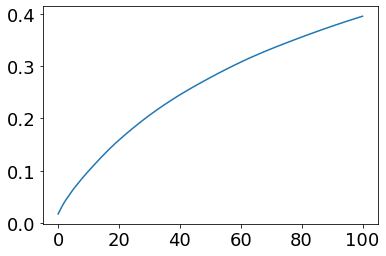

In [92]:
plt.plot(np.linspace(0,100,100),np.cumsum(pca.explained_variance_ratio_))

In [93]:
# lets try a stemmer
from nltk.stem import PorterStemmer

ps = PorterStemmer()

In [94]:
stemmed_tweets = [' '.join([ps.stem(w) for w in tweet.split(' ')]) for tweet in cleaned]

In [95]:
X_tweet_ps = vectorizer.fit_transform(stemmed_tweets)

In [96]:
pca.fit(X_tweet_ps.todense())

PCA(copy=True, iterated_power='auto', n_components=100, random_state=13,
    svd_solver='auto', tol=0.0, whiten=False)

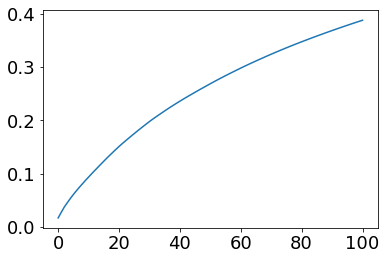

In [97]:
plt.plot(np.linspace(0,100,100),np.cumsum(pca.explained_variance_ratio_))

In [98]:
from nltk.stem import WordNetLemmatizer

lem = WordNetLemmatizer()

In [99]:
import nltk
nltk.download('wordnet')
lemmed_tweets = [' '.join([lem.lemmatize(w) for w in tweet.split(' ')]) for tweet in cleaned]

[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


In [100]:
lemmed_tweets[0]

'i’m one vote mail you ignorant idiot there are million an…'

In [101]:
X_tweet_lem = vectorizer.fit_transform(lemmed_tweets)

In [102]:
pca.fit(X_tweet_lem.todense())

PCA(copy=True, iterated_power='auto', n_components=100, random_state=13,
    svd_solver='auto', tol=0.0, whiten=False)

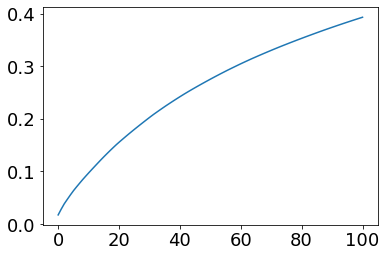

In [104]:
plt.plot(np.linspace(0,100,100),np.cumsum(pca.explained_variance_ratio_))

In [109]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_tweet, y_tweet_train['state'])
proba = mnb.predict_proba(X_tweet)

In [111]:
proba[:5,:]

array([[0.33065685, 0.34536228, 0.32398087],
       [0.2219891 , 0.62023458, 0.15777631],
       [0.33640596, 0.30845888, 0.35513516],
       [0.38727302, 0.35853727, 0.25418971],
       [0.35970307, 0.35115482, 0.28914211]])

In [113]:
y_tweet_train['state'][:5]

35617     1
109208    3
59606     2
53760     2
10718     1
Name: state, dtype: int64

In [114]:
mnb.score(X_tweet,y_tweet_train['state'])

0.41156848355460673

In [115]:
mnb.fit(X_tweet, y_tweet_train['search_term_key'])
proba = mnb.predict_proba(X_tweet)

In [116]:
proba[:5,:]

array([[0.52315323, 0.06647655, 0.01932961, 0.04912835, 0.34191225],
       [0.00359753, 0.00680072, 0.00427313, 0.0052793 , 0.98004933],
       [0.03387501, 0.08543639, 0.75052279, 0.0702433 , 0.05992251],
       [0.0870695 , 0.45894962, 0.00529416, 0.39906717, 0.04961954],
       [0.11035735, 0.44022579, 0.05190415, 0.30677058, 0.09074213]])

In [118]:
y_tweet_train['search_term_key'][:5]

35617     5
109208    5
59606     3
53760     2
10718     2
Name: search_term_key, dtype: int64

In [119]:
mnb.score(X_tweet,y_tweet_train['search_term_key'])

0.4883314430582427

In [128]:
mnb.fit(X_tweet_ps, y_tweet_train['search_term_key'])
y_hat = mnb.predict(X_tweet_ps)
mnb.score(X_tweet_ps,y_tweet_train['search_term_key'])

0.4939222096203883

In [137]:
from sklearn.metrics import precision_score, recall_score

In [149]:
precision = precision_score(y_tweet_train['search_term_key'], y_hat, labels=[1,2,3,4,5], average=None)
recall = recall_score(y_tweet_train['search_term_key'], y_hat, labels=[1,2,3,4,5], average=None)

In [150]:
print(precision)

[0.58745527 0.38840233 0.69063564 0.3925838  0.54314721]


In [151]:
print(recall)

[0.51710721 0.6466735  0.61000679 0.18773269 0.53368358]


In [154]:
# make roc curve
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.svm import LinearSVC

In [155]:
y = label_binarize(targets['search_term_key'], classes=[1,2,3,4,5])
n_classes = 5

tweet_text = final_df['tweet_text_wo_mentions']

# clean text
retweet_regex = "^RT @"
mentions_regex = "^@"
# should create column for is_rt
no_rt = [' '.join([w for w in tweet.split(' ') if not re.search(retweet_regex, w)]) for tweet in tweet_text]
# elim mentions
no_mentions = [' '.join([w for w in tweet.split(' ') if not re.search(mentions_regex, w)]) for tweet in no_rt]
no_tn = [' '.join(re.split(r'[ \t\n]+', tweet)) for tweet in no_mentions]
no_https = [' '.join([w for w in tweet.split(' ') if not re.search('^[https http]', w)]) for tweet in no_tn]
cleaned = [cleaner.clean_tweets(tweet,4) for tweet in no_https]

vectorizer = TfidfVectorizer(max_features=1000)
X_tweet = vectorizer.fit_transform(cleaned)

# shuffle and split training and test sets
X_train, X_test, y_train, y_test =\
    train_test_split(X_tweet, y, test_size=0.33, random_state=0, stratify=y)


# classifier
clf = OneVsRestClassifier(LinearSVC(random_state=0))
y_score = clf.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

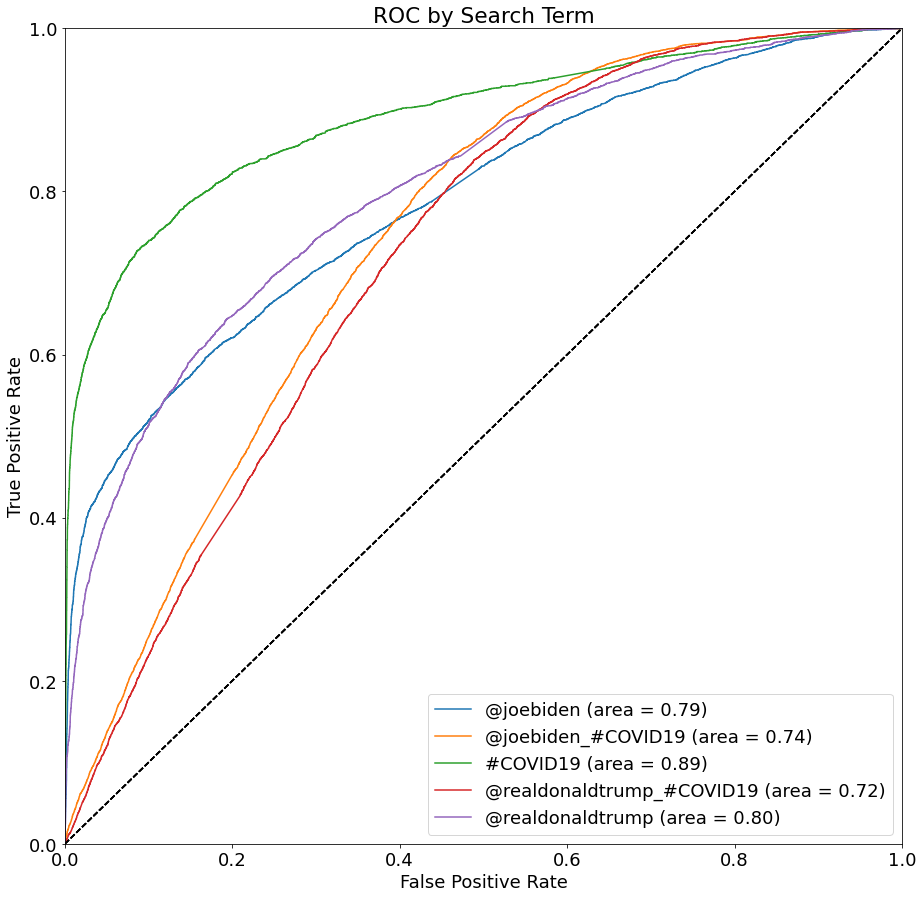

In [171]:
# Plot of a ROC curve for a specific class

term_dict = {1:'@joebiden', 2:'@joebiden_#COVID19', 3:'#COVID19', 4:'@realdonaldtrump_#COVID19', 5:'@realdonaldtrump'}

fig, ax = plt.subplots(1, figsize=(15,15))

for i in range(n_classes):
    ax.plot(fpr[i], tpr[i], label='{} (area = {:0.02f})'.format(term_dict.get(i+1), roc_auc[i]))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC by Search Term')
ax.legend(loc="lower right")
plt.show()

In [211]:
def mc_roc(ax, X_raw,targets, classes, label, label_dict, figsize=(12,12),stem=False):
    y = label_binarize(targets, classes=classes)
    n_classes = len(classes)

    tweet_text = X_raw

    # clean text
    retweet_regex = "^RT @"
    mentions_regex = "^@"
    # should create column for is_rt
    no_rt = [' '.join([w for w in tweet.split(' ') if not re.search(retweet_regex, w)]) for tweet in tweet_text]
    # elim mentions
    no_mentions = [' '.join([w for w in tweet.split(' ') if not re.search(mentions_regex, w)]) for tweet in no_rt]
    no_tn = [' '.join(re.split(r'[ \t\n]+', tweet)) for tweet in no_mentions]
    no_https = [' '.join([w for w in tweet.split(' ') if not re.search('^[https http]', w)]) for tweet in no_tn]
    cleaned = [cleaner.clean_tweets(tweet,4) for tweet in no_https]

    vectorizer = TfidfVectorizer(max_features=1000)

    if stem:
        ps = PorterStemmer()
        stemmed_tweets = [' '.join([ps.stem(w) for w in tweet.split(' ')]) for tweet in cleaned]
        X_tweet = vectorizer.fit_transform(stemmed_tweets)
    else:
        X_tweet = vectorizer.fit_transform(cleaned)
    
    # shuffle and split training and test sets
    X_train, X_test, y_train, y_test =\
        train_test_split(X_tweet, y, test_size=0.33, random_state=0, stratify=y)


    # classifier
    clf = OneVsRestClassifier(MultinomialNB())
    y_score = clf.fit(X_train, y_train).predict_proba(X_test)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='{} (area = {:0.02f})'.format(label_dict.get(i+1), roc_auc[i]))
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC by {}'.format(label))
    ax.legend(loc="lower right")
    return X_train, X_test, y_train, y_test

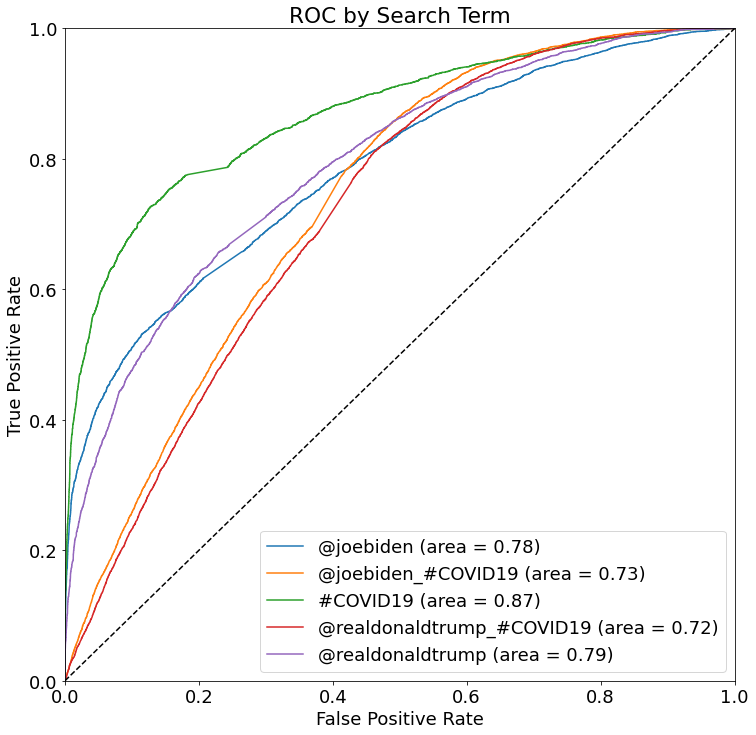

In [182]:
term_dict = {1:'@joebiden', 2:'@joebiden_#COVID19', 3:'#COVID19', 4:'@realdonaldtrump_#COVID19', 5:'@realdonaldtrump'}

mc_roc(final_df['tweet_text_wo_mentions'], targets['search_term_key'], [1,2,3,4,5],term_dict)

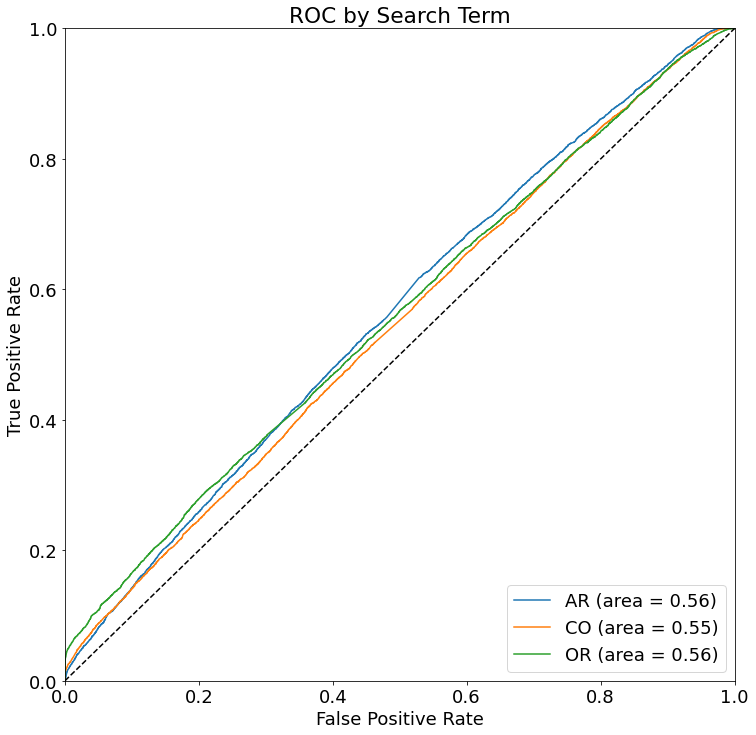

In [183]:
state_dict = {1:'AR', 2:'CO', 3:'OR'}
mc_roc(final_df['tweet_text_wo_mentions'], targets['state'], [1,2,3],state_dict)

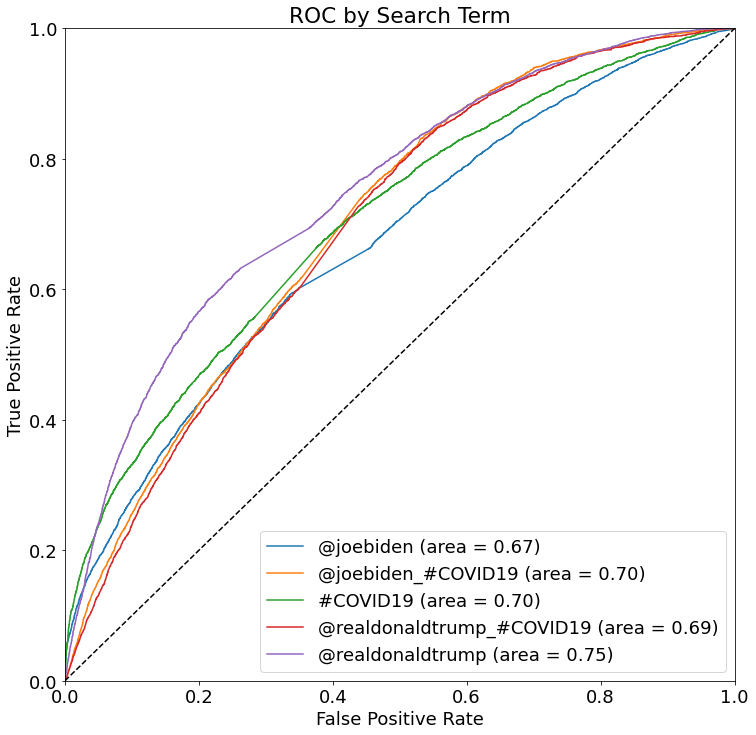

In [184]:
mc_roc(final_df['description'], targets['search_term_key'], [1,2,3,4,5],term_dict)

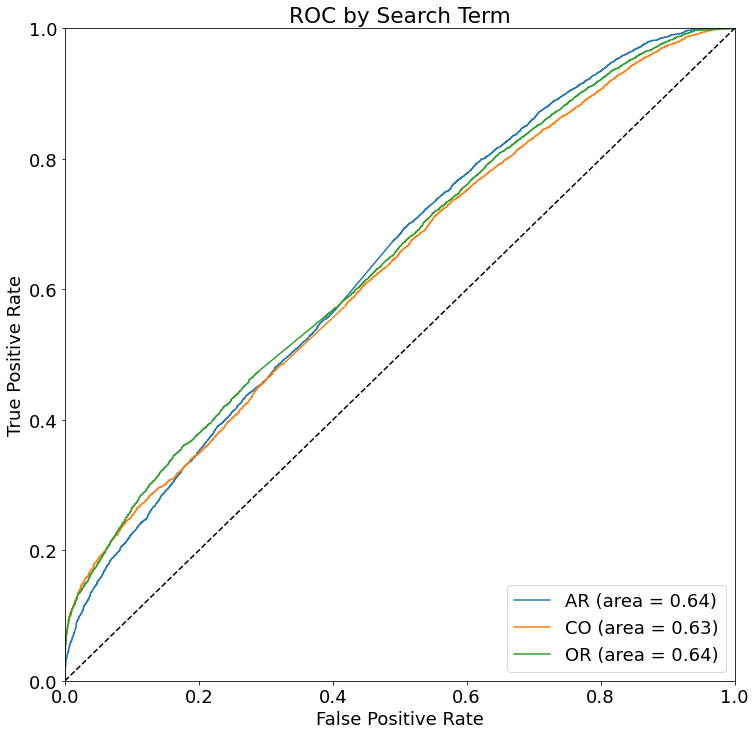

In [185]:
mc_roc(final_df['description'], targets['state'], [1,2,3],state_dict)

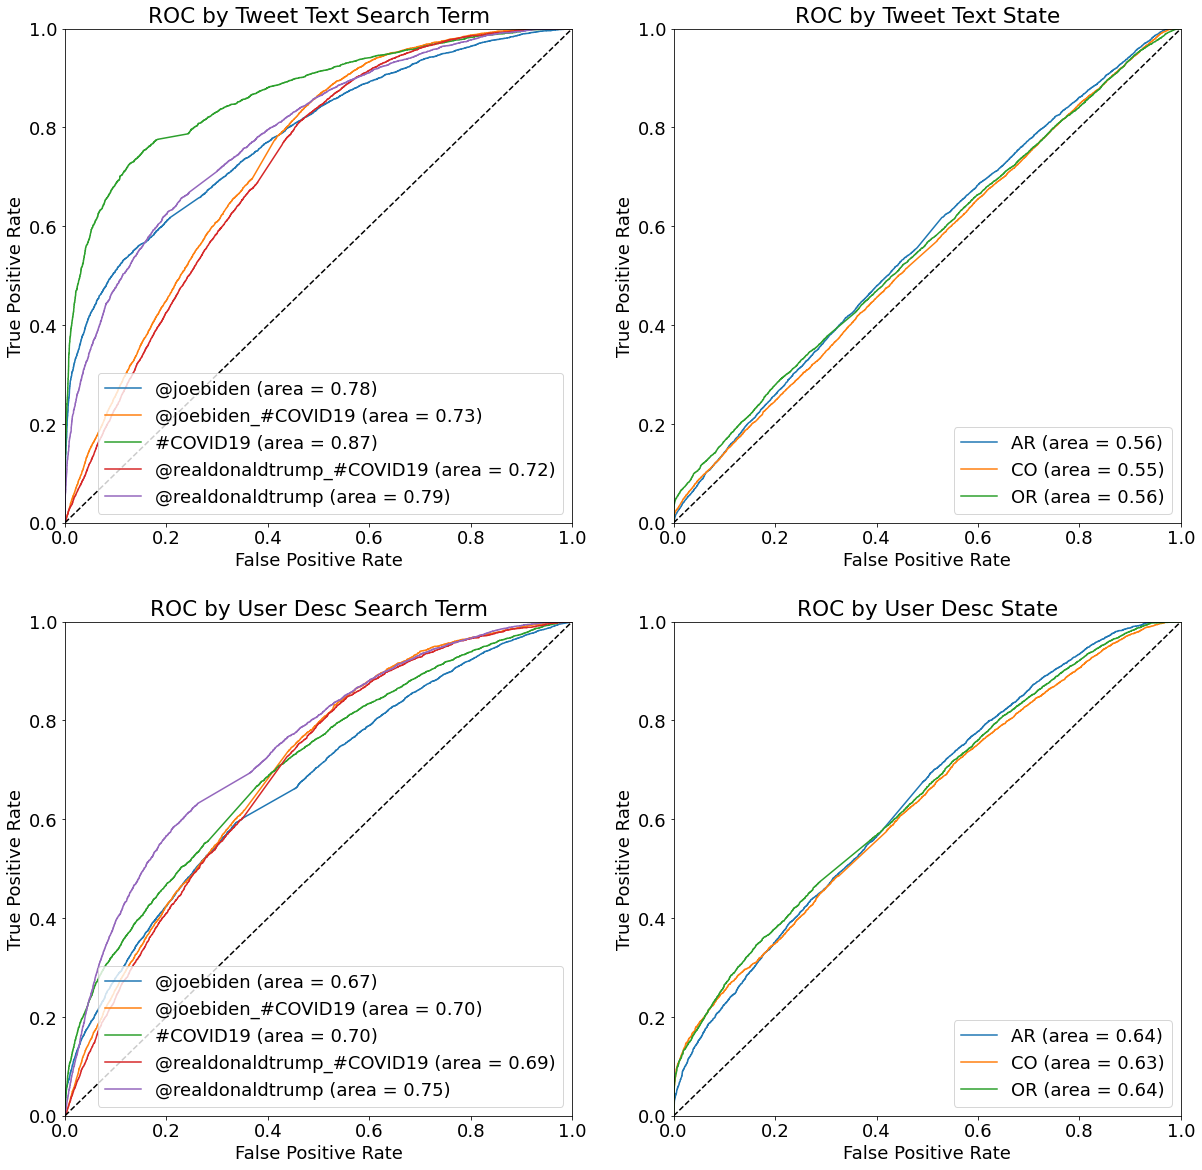

In [192]:
fig, axs = plt.subplots(2,2,figsize = (20,20))

mc_roc(axs[0,0], final_df['tweet_text_wo_mentions'], targets['search_term_key'], [1,2,3,4,5], 'Tweet Text Search Term',term_dict, figsize)
mc_roc(axs[0,1], final_df['tweet_text_wo_mentions'], targets['state'], [1,2,3], 'Tweet Text State', state_dict, figsize)
mc_roc(axs[1,0], final_df['description'], targets['search_term_key'], [1,2,3,4,5], 'User Desc Search Term', term_dict, figsize)
mc_roc(axs[1,1], final_df['description'], targets['state'], [1,2,3], 'User Desc State',state_dict, figsize)
plt.show()

In [196]:
# lets try to add user desc to tweet text
whole_text = final_df['tweet_text_wo_mentions'] + ' ' + final_df['description']
whole_text[:5]

0    lil pump really said "look at my wrist corona ...
1    @Stephan59177054 @NomikiKonst @JoeBiden I thou...
2    RT @Jali_Cat: Yet you’ve been in office since ...
4    RT @KaivanShroff: “I think it’s close to crimi...
5    @nickbixby @Michael58918973 @MSpicuzzaMJS @Syk...
dtype: object

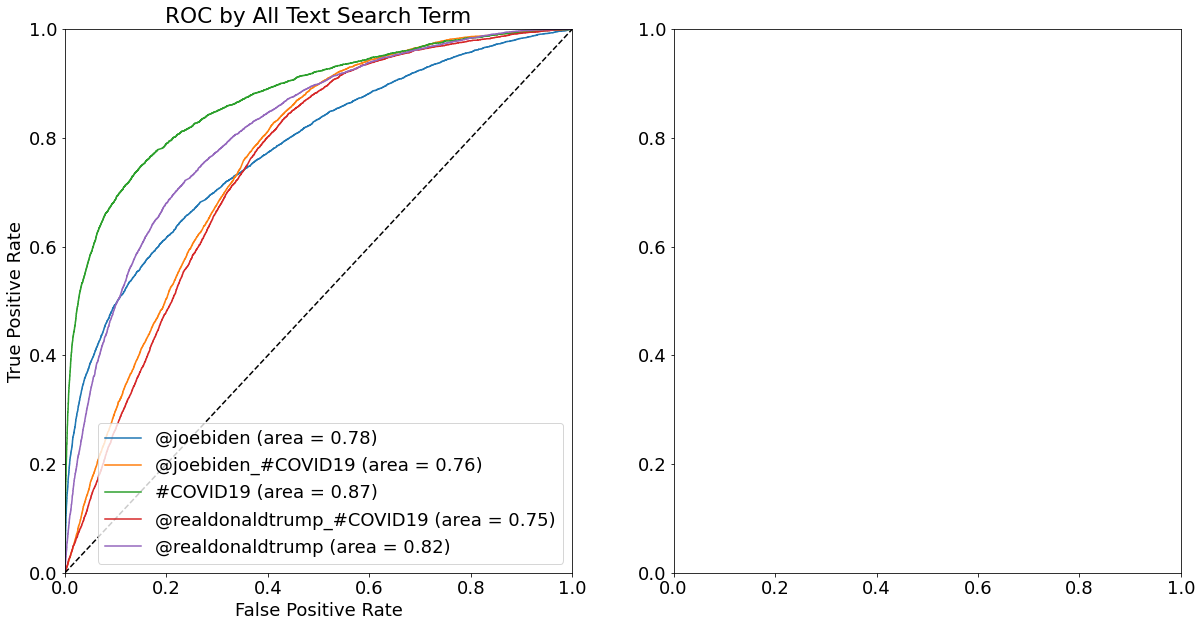

In [212]:
fig, axs = plt.subplots(1,2,figsize = (20,10))

X_train, X_test, y_train, y_test = mc_roc(axs[0], whole_text, targets['search_term_key'], [1,2,3,4,5], 'All Text Search Term',term_dict, figsize)
# mc_roc(axs[1], whole_text, targets['state'], [1,2,3], 'All Text State', state_dict, figsize)

In [213]:
# lets try clustering
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

In [215]:
pairwise_distancesns(n_clusters=8, random_state=13, n_jobs=-1)
kmeans.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=13, tol=0.0001, verbose=0)

In [232]:
distances = pairwise_distances(X_train, kmeans.cluster_centers_, n_jobs=-1)
score = np.sum(np.min(distances, axis=1))/X_train.shape[0]
score

0.9647387623858787

In [239]:
np.ones(ks.shape)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
ks = np.arange(1,16)
dists = np.ones(ks.shape)

for i,k in enumerate(ks):
    kmeans = KMeans(n_clusters=k, random_state=13,n_jobs=-1)
    kmeans.fit(X_train)
    dists[i] = kmeans.inertia_
    

In [ ]:
fig, ax = plt.subplots()
ax.plot(ks, dists)
ax.set_xlabel('Num Clusters')
ax.set_ylabel('Error metric')
plt.show()